## nn.RNN 介绍

```python
nn.RNN(input_size, hidden_size, 
    num_layers=1, nonlinearity=tanh, # 激活函数
    bias=True, batch_first=False, 
    dropout=0, bidirectional=False)
input_shape = [时间步数, 批量大小, 特征维度] = [num_steps, batch_size, input_dim]

[batch_size, input_dim] * [input_dim, num_hiddens] + [batch_size, num_hiddens] *[num_hiddens, num_hiddens] +bias
```

实际上最后返回的是具体实现的$$H_t = X_t \times W_{xh} + H_{t-1} \times W_{hh} + b_h$$

In [7]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [8]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [9]:
state = torch.zeros((1, batch_size, num_hiddens))
# [num_state_hidden, batch_size, hiddens]
state.shape

torch.Size([1, 32, 256])

In [10]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
print(f'y.shape = {Y.shape}, state.shape = {state_new.shape}')
# [num_steps, batch_size, num_hiddens]

y.shape = torch.Size([35, 32, 256]), state.shape = torch.Size([1, 32, 256])


In [11]:
#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size) # 所以最后要加一个全连接层
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [15]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerdongwmlkdx'

perplexity 3.5, 526964.0 tokens/sec on cuda:0
time traveller to the time traveller can move about in to sayich
travellerit said the medinglerimental very yell threely on 


'time traveller to the time travell'

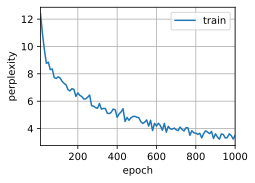

In [16]:
num_epochs, lr = 1000, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

d2l.predict_ch8('time traveller', 20, net, vocab, device)